Special Thanks to Jan S, Data Scientist in Kaggle for his data on property prices in Kuala Lumpur that are scrapped from website iProperty (https://www.iproperty.com.my/). Link for data https://www.kaggle.com/dragonduck/property-listings-in-kuala-lumpur

From here we can make a statistical analysis. We will also try to build a predictive model based on the data available.

Mounting the data from google drive into Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Importing All Important Libraries

In [ ]:
import numpy as np
np.random.seed(101)
import requests
import time
import os
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os
import re
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.linear_model
import sklearn.feature_selection
import sklearn.preprocessing
import sklearn.metrics
import keras.models
import keras.layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


CHAPTER 1: DATA PREPROCESSING

The raw data that collected in kaggle need to be processed to get a clean data that can be used in the analysis. The data also needs to be standardized for our use. Some of fields for particular property is empty

Loading the data into properties variable. The data is put into pandas data frame. Here Pandas Library is used.

In [ ]:
properties = pd.read_csv("/content/drive/My Drive/malaysia_data.csv")

We check for the data after loading. .head() function simply shows first five items of the data frame.

In [ ]:
properties.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
0,"KLCC, Kuala Lumpur","RM 1,250,000",2+1,3.0,2.0,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished
1,"Damansara Heights, Kuala Lumpur","RM 6,800,000",6,7.0,NaN,Bungalow,Land area : 6900 sq. ft.,Partly Furnished
2,"Dutamas, Kuala Lumpur","RM 1,030,000",3,4.0,2.0,Condominium (Corner),"Built-up : 1,875 sq. ft.",Partly Furnished
3,"Cheras, Kuala Lumpur",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Bukit Jalil, Kuala Lumpur","RM 900,000",4+1,3.0,2.0,Condominium (Corner),"Built-up : 1,513 sq. ft.",Partly Furnished


As we can see here not all field is filled. Some of the field in the form that ease us to analyse the data

Here we remove properties without price. isna() is the function to detect any missing data in the data frame.


In [ ]:
properties = properties.loc[~properties["Price"].isna()]

Then, we search for data that has wrong price format. The format should contain value or comma after RM. If there is missing data it will shows up the count.

In [ ]:
incorrect_entries = np.sum(~properties["Price"].str.match(r"RM [0-9,]*$"))
print("There are {} entries in the wrong format.".format(incorrect_entries))

There are 0 entries in the wrong format.


The we strip the price. This is done to standardized the data.

In [ ]:
def strip_price(text):
    text = text.replace("RM", "")
    text = text.replace(",", "")
    text = text.strip()
    return int(text)
    
properties["Price"] = properties["Price"].apply(strip_price)

Another problem is capitalization,some of the data is captialized some is not. We want all of the to be lower case, so we convert them. City name is removed as all of properties are from Kuala Lumpur.

In [ ]:
properties["Location"] = properties["Location"].str.lower()
properties["Location"] = properties["Location"].str.replace(r", kuala lumpur$", "")

So here we can see the all the location listed in the entries. Sorted fucntion simply sort the data beginning with 'a' until 'z'.

In [ ]:
sorted(properties["Location"].unique())

['adiva desa parkcity',
 'alam damai',
 'ampang',
 'ampang hilir',
 'bandar damai perdana',
 'bandar menjalara',
 'bandar sri damansara',
 'bandar tasik selatan',
 'bangsar',
 'bangsar south',
 'batu caves',
 'brickfields',
 'bukit  persekutuan',
 'bukit bintang',
 'bukit damansara',
 'bukit jalil',
 'bukit kiara',
 'bukit ledang',
 'bukit tunku (kenny hills)',
 'canary residence',
 'casa rimba',
 'chan sow lin',
 'cheras',
 'city centre',
 'country heights damansara',
 'cyberjaya',
 'damansara',
 'damansara heights',
 'desa pandan',
 'desa parkcity',
 'desa petaling',
 'duta nusantara',
 'dutamas',
 'federal hill',
 'gombak',
 'gurney',
 'happy garden',
 'jalan ipoh',
 'jalan klang lama (old klang road)',
 'jalan kuching',
 'jalan sultan ismail',
 'jalan u-thant',
 'jinjang',
 'kemensah',
 'kepong',
 'keramat',
 'kl city',
 'kl eco city',
 'kl sentral',
 'klcc',
 'kota damansara',
 'kuala lumpur',
 'kuchai lama',
 'landed sd',
 'mid valley city',
 'mont kiara',
 'off gasing indah,',
 

Now let check the frequency distribution. Here frequency distribution is plotted logarithmically. Some regions has very few properties listed. This make our prediction and graph later on difficult to work with.

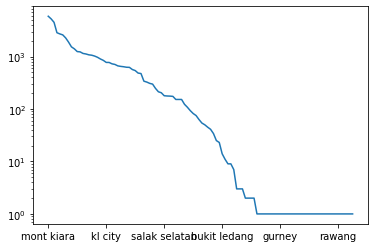

In [ ]:
properties["Location"].value_counts().plot(logy=True);

So the next step is to trim the data. Locations with fewer than 100 properties listed are removed from the candidates to be analyzed. 

In [ ]:
significant_locations = properties["Location"].value_counts()[
    properties["Location"].value_counts() >= 100].index

properties = properties.loc[np.isin(properties["Location"], significant_locations)]

So here we see the list again to check them. We supposed to get less location here as we are already cut down the data.

In [ ]:
sorted(properties["Location"].unique())

['ampang',
 'ampang hilir',
 'bandar damai perdana',
 'bandar menjalara',
 'bangsar',
 'bangsar south',
 'batu caves',
 'brickfields',
 'bukit bintang',
 'bukit jalil',
 'bukit tunku (kenny hills)',
 'cheras',
 'city centre',
 'country heights damansara',
 'damansara heights',
 'desa pandan',
 'desa parkcity',
 'desa petaling',
 'dutamas',
 'jalan ipoh',
 'jalan klang lama (old klang road)',
 'jalan kuching',
 'jalan sultan ismail',
 'kepong',
 'keramat',
 'kl city',
 'kl eco city',
 'kl sentral',
 'klcc',
 'kuchai lama',
 'mont kiara',
 'oug',
 'pandan perdana',
 'pantai',
 'salak selatan',
 'segambut',
 'sentul',
 'seputeh',
 'setapak',
 'setiawangsa',
 'sri hartamas',
 'sri petaling',
 'sungai besi',
 'sunway spk',
 'taman desa',
 'taman melawati',
 'taman tun dr ismail',
 'titiwangsa',
 'wangsa maju']

The number of rooms contains format irregularities. Here we can see it is common for rooms to be listed as N+M instead of the total number of rooms. We need to make new format to ease us to analyze. astype() is the function to print them as string otherwise it will be added up when printed.

In [ ]:
sorted(properties["Rooms"].unique().astype(str))

['1',
 '1+1',
 '1+2',
 '10',
 '10+',
 '10+1',
 '11',
 '11+1',
 '12',
 '12+',
 '13',
 '13+',
 '13+1',
 '14',
 '15+',
 '16',
 '18',
 '2',
 '2+1',
 '2+2',
 '20 Above',
 '3',
 '3+1',
 '3+2',
 '4',
 '4+1',
 '4+2',
 '5',
 '5+1',
 '5+2',
 '6',
 '6+',
 '6+1',
 '7',
 '7+',
 '7+1',
 '8',
 '8+',
 '8+1',
 '9',
 '9+',
 '9+1',
 'Studio',
 'nan']

Here is the function to convert the format into single number. We simply check for all properties, putting the into if statements.

In [ ]:
def convert_room_num(rooms):
    try:
        if rooms.endswith("+"):
            return int(rooms[:-1])
        if re.search("[0-9]+\+[0-9]+", rooms) is not None:
            tmp = rooms.split("+")
            return int(tmp[0]) + int(tmp[1])
        if rooms == "20 Above":
            return 20
        if rooms == "Studio":
            return 1
        return int(rooms)
    except AttributeError:
        return rooms

properties["Rooms Num"] = properties["Rooms"].apply(convert_room_num)

So we check again the data. Here, we can see it us in the form of number. So the steps are done for the Rooms Num.

In [ ]:
properties["Rooms Num"].value_counts(dropna=False)

3.0     15938
4.0     13027
5.0      6827
2.0      6547
6.0      3747
1.0      3191
7.0      1564
NaN      1560
8.0       361
9.0       102
10.0       45
12.0       14
11.0        8
20.0        7
13.0        4
14.0        3
16.0        2
18.0        1
15.0        1
Name: Rooms Num, dtype: int64

So now we see the property type available in the data. Obviously it is very long data so we need to simplify it to assist our analysis.

In [ ]:
properties["Property Type"].value_counts()

Condominium                             11447
Serviced Residence                       7176
Condominium (Corner)                     5687
Condominium (Intermediate)               5113
Serviced Residence (Intermediate)        3255
                                        ...  
Semi-detached House (SOHO)                  1
Cluster House                               1
4-sty Terrace/Link House (Penthouse)        1
2.5-sty Terrace/Link House (Triplex)        1
4.5-sty Terrace/Link House (Corner)         1
Name: Property Type, Length: 95, dtype: int64

Here is the function that converts them from mini groups into super groups. It is just new categories that can fit some groups with same types.

In [ ]:
def simplify_property_type(prop_type):
    super_types = [
        "Terrace/Link House", "Serviced Residence", "Condominium", 
        "Semi-detached House", "Bungalow", "Apartment", "Townhouse", 
        "Flat", "Residential Land", "Cluster House"]
    for super_type in super_types:
        if re.search(super_type, prop_type, flags=re.IGNORECASE) is not None:
            return super_type
    
    return prop_type

properties["Property Type Supergroup"] = properties["Property Type"].apply(simplify_property_type)

So we check again the data. Good, now the types are reduced.

In [ ]:
properties["Property Type Supergroup"].value_counts(dropna=False)

Condominium            23149
Serviced Residence     13399
Terrace/Link House      7567
Bungalow                3598
Semi-detached House     2102
Apartment               1621
Residential Land         669
Townhouse                508
Flat                     330
Cluster House              6
Name: Property Type Supergroup, dtype: int64

So we jump to furnishing. It is already in the format that we do not need to clean.

In [ ]:
properties["Furnishing"].value_counts(dropna=False)

Partly Furnished    26222
Fully Furnished     13846
NaN                  6687
Unfurnished          5611
Unknown               583
Name: Furnishing, dtype: int64

So lets see the Size feature. All the sizes here in the string format. Here we see the sample of 25 items.

In [ ]:
properties[["Size"]].sample(25)

,Size
44370,"Built-up : 9,000 sq. ft."
24474,"Built-up : 2,002 sq. ft."
38244,Land area : 3046 sq. ft.
11381,Built-up : 522 sq. ft.
36948,Land area : 1659 sq. ft.
45748,Built-up : 950 sq. ft.
48529,Land area : 6000 sq. ft.
36563,Built-up : 729 sq. ft.
36203,"Built-up : 3,983 sq. ft."
16770,Built-up : 900 sq. ft.


Because of landed area and built up are two different features, we need to split them up accordingly. Here is the function to create two new column that indicate whether this is built-up or land area.

In [ ]:
def split_size(val, index=0):
    try:
        return val.split(":")[index].strip()
    except AttributeError:
        return val
    
properties["Size Type"] = properties["Size"].apply(split_size, index=0)
properties["Size Num"] = properties["Size"].apply(split_size, index=1)

So we check the count number . There should be two type in Size Type.

In [ ]:
properties["Size Type"].value_counts(dropna=False)

Built-up     37493
Land area    14453
NaN           1003
Name: Size Type, dtype: int64

So need to convert the num Size into number type in order to do analysis. Below is the function to convert it.

In [ ]:
def convert_size_num(size):
    try:
        # If it is not in form of square feet simply ignore it.
        if re.search(r"sq\.*\s*ft\.*", size) is None:
            return None
    
        size = size.replace(",", "")
        size = size.replace("'", "")
        size = size.replace("sq. ft.", "")
        size = size.replace("sf", "")
        size = size.strip()
        size = size.lower()
        
        add_mult_match = re.search(r"(\d+)\s*\+\s*(\d+)\s*(?:x|\*)\s*(\d+)", size)
        if add_mult_match is not None:
            return int(add_mult_match.groups()[0]) + (
                int(add_mult_match.groups()[1]) * 
                int(add_mult_match.groups()[2]))
        
        mult_match = re.search(r"(\d+)\s*(?:x|\*)\s*(\d+)", size)
        if mult_match is not None:
            return int(mult_match.groups()[0]) * int(mult_match.groups()[1])
        
        return int(size)
    # If none of the steps works, we simply return none. This is important because we want to make sure it is numeric.
    except:
        return None
        
properties["Size Num"] = properties["Size Num"].apply(convert_size_num)

So we check the data again. Here we need the count for the data that we want and also which has missing data and data type.

In [ ]:
print("Properties with missing raw size data: {}".format(properties["Size"].isna().sum()))
print("Properties with missing size type data: {}".format(properties["Size Type"].isna().sum()))
print("Properties with missing size num data: {}".format(properties["Size Num"].isna().sum()))

Properties with missing raw size data: 1003
Properties with missing size type data: 1003
Properties with missing size num data: 1313


Here we synchronize the missing values between the Size Type and Size Num columns in the data frame.


In [ ]:
properties.loc[properties["Size Num"].isna(), "Size Type"] = None

So here we check again the count number for the Size Type.

In [ ]:
properties.loc[:, "Size Type"].value_counts(dropna=False)

Built-up     37455
Land area    14181
NaN           1313
Name: Size Type, dtype: int64

Lets check the bathrooms data. It seems doesnt need any modification as it is standardized.

In [ ]:
properties["Bathrooms"].value_counts(dropna=False)

2.0     21163
3.0      9331
4.0      6522
5.0      4717
1.0      4482
6.0      3172
NaN      1866
7.0      1031
8.0       402
9.0       142
10.0       70
12.0       14
11.0       11
20.0       10
15.0        6
13.0        5
14.0        4
16.0        1
Name: Bathrooms, dtype: int64

The car park data also is already standardized.

In [ ]:
properties["Car Parks"].value_counts(dropna=False)

NaN     17042
2.0     15174
1.0     13622
3.0      3798
4.0      1913
6.0       623
5.0       501
8.0        91
10.0       76
7.0        62
15.0        7
12.0        7
13.0        7
20.0        4
11.0        4
9.0         4
30.0        4
28.0        4
16.0        2
17.0        2
18.0        1
24.0        1
Name: Car Parks, dtype: int64

So here we want to introduced new features from the existing parameters which are price per area and price per room. This feauture can be the new dependent variable for our model.

In [ ]:
properties["Price per Area"] = properties["Price"] / properties["Size Num"]
properties["Price per Room"] = properties["Price"] / properties["Rooms Num"]

Then we need to save the processed data into the drive in .csv type

In [ ]:
properties.to_csv("/content/drive/My Drive/Properties_preprocessed.csv")

Here we try to look for first 5 data that we just saved.  We can see here there are new columns with numeric values and standarized data that we can use for our analysis.

In [ ]:
properties.head()

,Unnamed: 0,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing,Rooms Num,Property Type Supergroup,Size Type,Size Num,Price per Area,Price per Room
0,0,klcc,1250000,2+1,3.0,2.0,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished,3.0,Serviced Residence,Built-up,1335.0,936.329588,4.166667e+05
1,1,damansara heights,6800000,6,7.0,NaN,Bungalow,Land area : 6900 sq. ft.,Partly Furnished,6.0,Bungalow,Land area,6900.0,985.507246,1.133333e+06
2,2,dutamas,1030000,3,4.0,2.0,Condominium (Corner),"Built-up : 1,875 sq. ft.",Partly Furnished,3.0,Condominium,Built-up,1875.0,549.333333,3.433333e+05
3,4,bukit jalil,900000,4+1,3.0,2.0,Condominium (Corner),"Built-up : 1,513 sq. ft.",Partly Furnished,5.0,Condominium,Built-up,1513.0,594.844679,1.800000e+05
4,5,taman tun dr ismail,5350000,4+2,5.0,4.0,Bungalow,Land area : 7200 sq. ft.,Partly Furnished,6.0,Bungalow,Land area,7200.0,743.055556,8.916667e+05


CHAPTER 2: DATA EXPLORATION

How we are going to analyze the data if we do not know about it right? So here we tried to plot some graphs to gain some knowledge of our data. This step is more on statistical side. 

Below is the code to load the standardized data if the preprocessed data already available. This is to skip the preprocessing steps. Simply skip this code if you have done the process.

In [ ]:
properties = pd.read_csv("/content/drive/My Drive/Properties_preprocessed.csv") #This code is only run if you want to skipped step before

Below is the function to plot by any parameter of features that we want to know. It is a function that we use to to plot anything respected to the neighbourhood (area in the simple word).

In [ ]:
# This function accept feature, formatting and also factor. The factor is how can we simplify the number. For example 1e6 is 10 power of 6 which are million.
def plot_by_neighborhood(feature, formatting, factor=1):
    df = properties.groupby("Location")[feature].median().sort_values(ascending=False).reset_index()
    shift = 0.1 * (df[feature].max() - df[feature].min())
    df_sizes = properties.groupby("Location").size()[df["Location"]]

    fig = sns.catplot(
        data=df, x=feature, y="Location", kind="bar", 
        color="darkgrey", height=10, aspect=0.8)

    for index, row in df.iterrows():
        fig.ax.text(
            row[feature] + shift, row.name, formatting.format(row[feature] / factor), 
            color='black', ha="center", va="center")

    fig.ax.get_xaxis().set_visible(False);
    fig.despine(left=True, bottom=True)
    fig.ax.tick_params(left=False, bottom=False);
    fig.set_ylabels("");

Total Prices per Neighborhood. This to show the areas respected to the total prices in each area. 

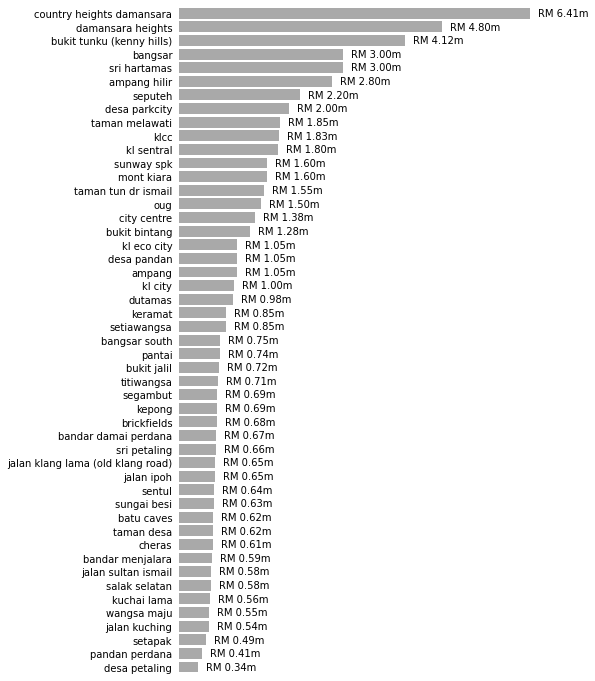

In [ ]:
plot_by_neighborhood(feature="Price", formatting="RM {:.2f}m", factor = 1e6)

Price per Square Foot per Neighborhood. Plotting Graph area respected to per square foot prices.

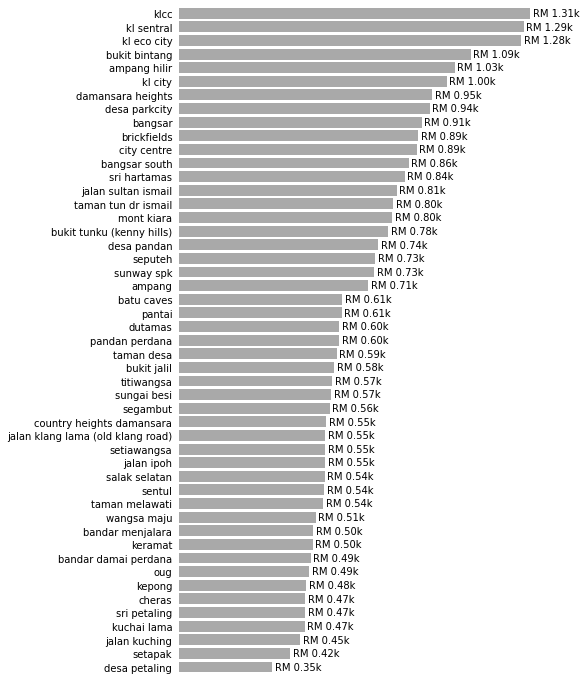

In [ ]:
plot_by_neighborhood(feature="Price per Area", formatting="RM {:.2f}k", factor = 1e3)

Price per Room per Neighborhood. Plotting the graph price per room in respected areas.

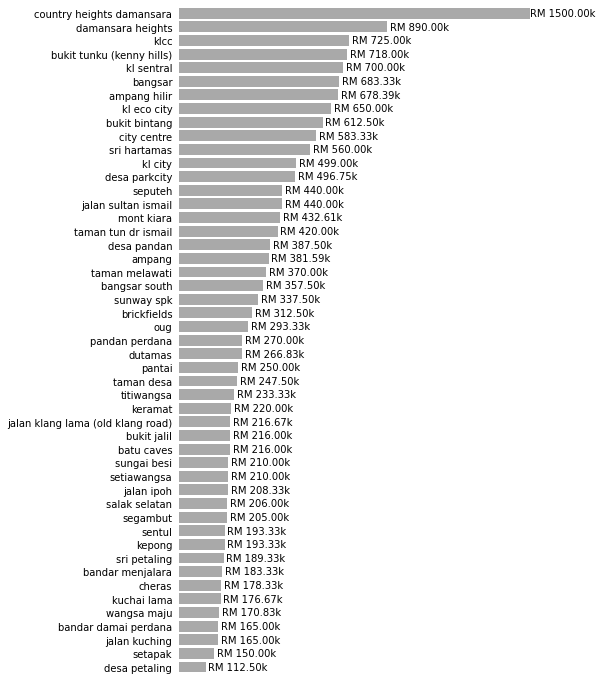

In [ ]:
plot_by_neighborhood(feature="Price per Room", formatting="RM {:.2f}k", factor = 1e3)


Property Size per Neighborhood. Plotting graph showing which the area how many area in contain in the data frame.

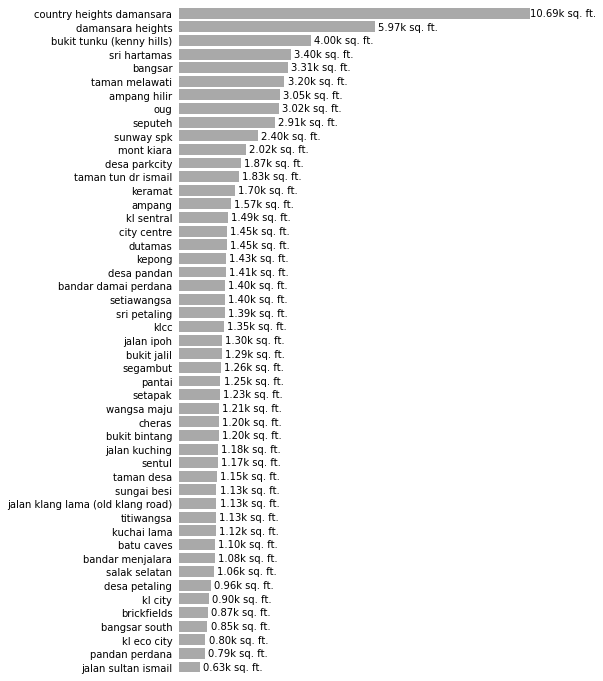

In [ ]:
plot_by_neighborhood(feature="Size Num", formatting="{:.2f}k sq. ft.", factor = 1e3)


Rooms per Neighborhood

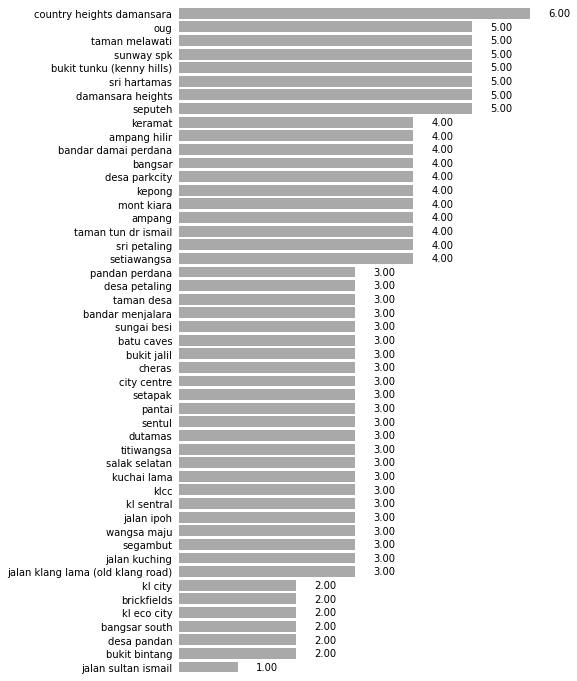

In [ ]:
plot_by_neighborhood(feature="Rooms Num", formatting="{:.2f}", factor = 1)

Number of Properties per Neighborhood. This time we want to know how many properties each area in out data frame.

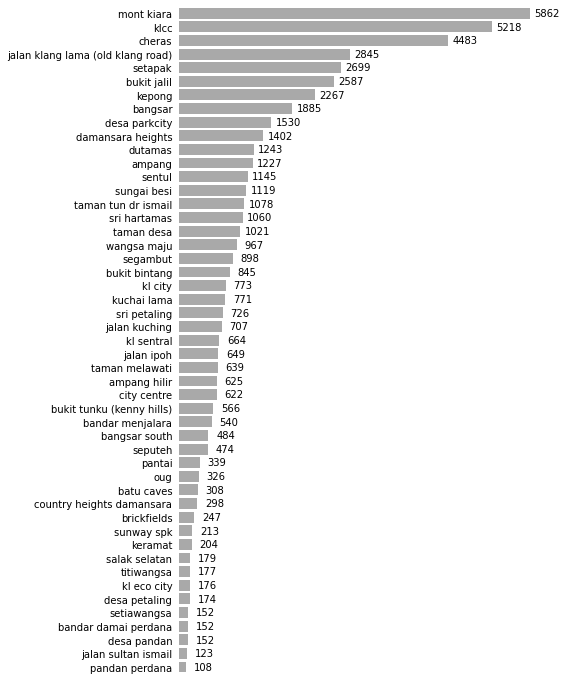

In [ ]:
df = properties.groupby("Location").size().sort_values(ascending=False).reset_index()
shift = 0.05 * (df[0].max() - df[0].min())
df_sizes = properties.groupby("Location").size()[df["Location"]]

fig = sns.catplot(
    data=df, x=0, y="Location", kind="bar", 
    color="darkgrey", height=10, aspect=0.8)

for index, row in df.iterrows():
    fig.ax.text(
        row[0] + shift, row.name, row[0], 
        color='black', ha="center", va="center")

fig.ax.get_xaxis().set_visible(False);
fig.despine(left=True, bottom=True)
fig.ax.tick_params(left=False, bottom=False);
fig.set_ylabels("");

Now, lets plot the heat map. This is to show the most common property type per neighborhood. The stronger the colour the more common they are.

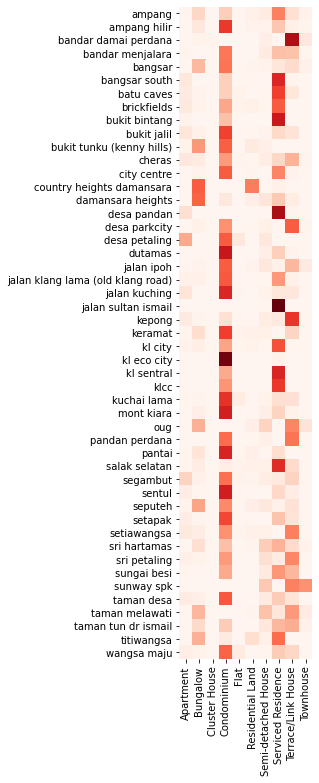

In [ ]:
# Taking the property type and putting them into a two-column data frame
df = properties.loc[~properties["Property Type Supergroup"].isna()].groupby(
    "Location")["Property Type Supergroup"].value_counts()
df.name = "Value"
df = df.reset_index().pivot(index="Location", columns="Property Type Supergroup")
df.columns = df.columns.droplevel(0)
df = df.fillna(0)

# we normalize the value to see the relativity of the data
df_norm = df.apply(lambda x: x / x.sum(), axis=1)

fix, ax = plt.subplots(figsize=(12, 12))
hmap = sns.heatmap(
    df_norm, square=True, vmin=0, cmap="Reds", ax=ax, cbar=False)
hmap.set_ylabel(None);
hmap.set_xlabel(None);

As mentioned earlier, land and built are two different thing that we cannot simply compare them. So we need to know how many land and built for each area.Land vs. Built-Up Area per Neighborhood

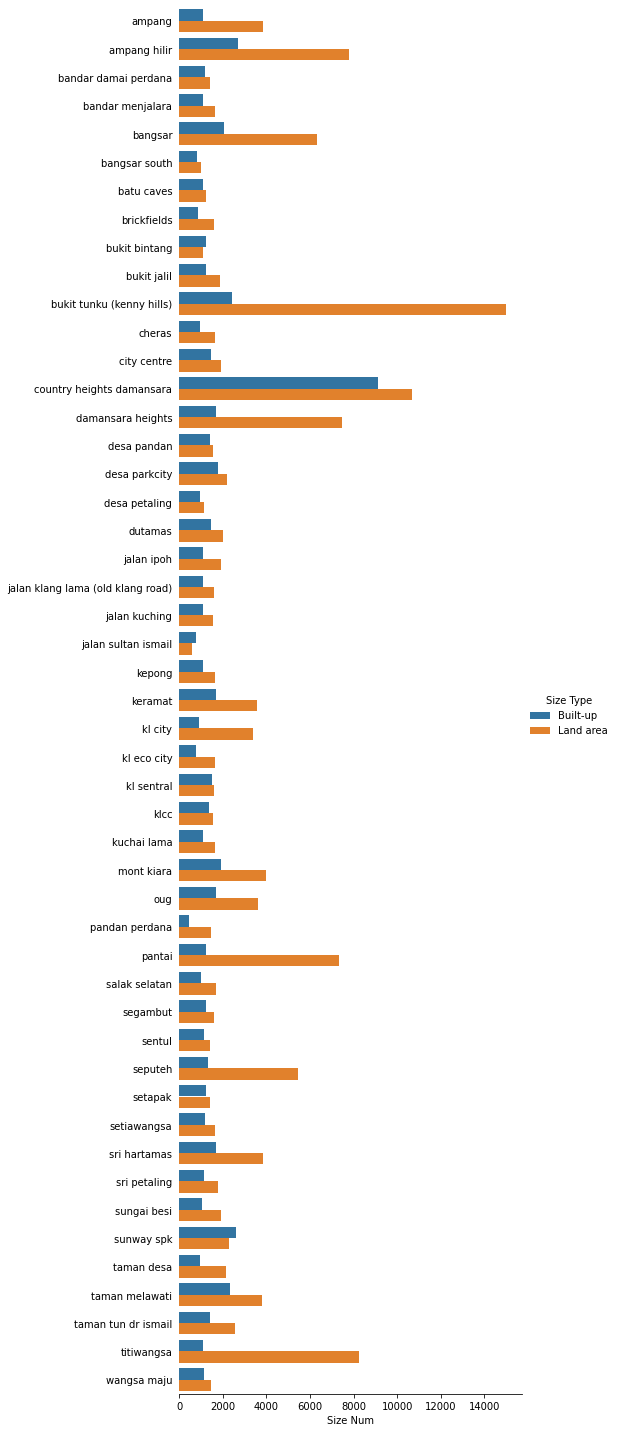

In [ ]:
df = properties[["Location", "Size Type", "Size Num"]].groupby(
    ["Location", "Size Type"]).median().reset_index()
fig = sns.catplot(
    data=df, x="Size Num", y="Location", kind="bar", 
    hue="Size Type", height=20, aspect=0.4);

fig.despine(left=True)
fig.ax.tick_params(left=False);
fig.set_ylabels("");

CHAPTER 3: FEATURE PROCESSING

3.1 Feature Selection

Here is the consideration for our data. This is done to simplify the model and gain more accurate result later on:

    Only "built-up" type is considered. We cannot mix land and built up because they can cause problems in our result later on.
    Look only at entries without missing values for features.

This means our model will only consider the following features:

    Location (converted to binary dummy features)
    Bathrooms
    Car Parks
    Furnishing
    Rooms Num
    Property Type Supergroup
    Size Num

The model will be trained to predict three dependent variables which are the price columns, Price, Price per Area, and Price per Room.

Missing car park will be replace by 0. It might be not true but it is for the simplicity of our model. We dont make the same assumption on bathroom which should be at least one. We also remove furnishing with unknown status making it hard for the modelling.

In [ ]:
# Collect data that only has built up type
Xy = properties.loc[properties["Size Type"] == "Built-up"]

# We only keep the features we want to use in our modelling.
Xy = Xy.loc[:, [
    "Location", "Bathrooms", "Car Parks", "Furnishing", 
    "Rooms Num", "Property Type Supergroup", "Size Num", 
    "Price", "Price per Area", "Price per Room"]]

# Replace any missing car park value with zero
Xy.loc[:, "Car Parks"] = Xy["Car Parks"].fillna(0)

# Remove properties with missing values other than carpark
Xy = Xy.loc[Xy.isna().sum(axis=1) == 0]

# Remove properties with unknown furnishing status.
Xy = Xy.loc[Xy["Furnishing"] != "Unknown"]

# Convert to dummy features. It is important as our modelling should be only containing numbers.
Xy = pd.get_dummies(Xy)

Now lets check how the data looks. It now looks very neat for our modelling.

In [ ]:
Xy.head()

,Bathrooms,Car Parks,Rooms Num,Size Num,Price,Price per Area,Price per Room,Location_ampang,Location_ampang hilir,Location_bandar damai perdana,Location_bandar menjalara,Location_bangsar,Location_bangsar south,Location_batu caves,Location_brickfields,Location_bukit bintang,Location_bukit jalil,Location_bukit tunku (kenny hills),Location_cheras,Location_city centre,Location_country heights damansara,Location_damansara heights,Location_desa pandan,Location_desa parkcity,Location_desa petaling,Location_dutamas,Location_jalan ipoh,Location_jalan klang lama (old klang road),Location_jalan kuching,Location_jalan sultan ismail,Location_kepong,Location_keramat,Location_kl city,Location_kl eco city,Location_kl sentral,Location_klcc,Location_kuchai lama,Location_mont kiara,Location_oug,Location_pandan perdana,Location_pantai,Location_salak selatan,Location_segambut,Location_sentul,Location_seputeh,Location_setapak,Location_setiawangsa,Location_sri hartamas,Location_sri petaling,Location_sungai besi,Location_sunway spk,Location_taman desa,Location_taman melawati,Location_taman tun dr ismail,Location_titiwangsa,Location_wangsa maju,Furnishing_Fully Furnished,Furnishing_Partly Furnished,Furnishing_Unfurnished,Property Type Supergroup_Apartment,Property Type Supergroup_Bungalow,Property Type Supergroup_Condominium,Property Type Supergroup_Flat,Property Type Supergroup_Residential Land,Property Type Supergroup_Semi-detached House,Property Type Supergroup_Serviced Residence,Property Type Supergroup_Terrace/Link House,Property Type Supergroup_Townhouse
0,3.0,2.0,3.0,1335.0,1250000,936.329588,416666.666667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,4.0,2.0,3.0,1875.0,1030000,549.333333,343333.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
3,3.0,2.0,5.0,1513.0,900000,594.844679,180000.000000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
7,2.0,1.0,3.0,904.0,385000,425.884956,128333.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
13,7.0,0.0,6.0,4842.0,4500000,929.368030,750000.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0


Now we check the shape. Shape function simply tells us how many column and how many rows we have. In the below situation, it is 32413 datas with 68 columns.

In [ ]:
print("Shape of data frame: {}".format(Xy.shape))

Shape of data frame: (32413, 68)


Now lets see what type of data in our dataframe.


In [ ]:
print("Data frame DTYPES:")
for dtype in Xy.dtypes.unique():
    print(" - {}".format(dtype))

Data frame DTYPES:
 - float64
 - int64
 - uint8


Because of some too big and too small data can be a thorn in our prediction and graph later, we remove Size Num outliers heuristically. Here we sorted the data to see how is the smallest size.

So here is the first 10 sorted data. The smallest reasonable value, as can be seen from the data, corresponds to 250
square feet. This corresponds to a small studio apartment. Therefore we use this as the lower threshold for potential values.

In [ ]:
Xy["Size Num"].sort_values().head(10)

7613      11.0
25889    250.0
43557    250.0
42397    250.0
23189    250.0
48544    250.0
52514    250.0
32912    250.0
41337    250.0
51410    250.0
Name: Size Num, dtype: float64

Lets see how big the size could be. There appear to be several unreasonably large properties (820000 square feet corresponds to the approximate size of the Louvre museum in Paris, France).

In [ ]:
Xy["Size Num"].sort_values(ascending=False).head(20)

25890    820000.0
2395     790000.0
23152    690000.0
9196     576000.0
49975    320015.0
42784    166821.0
49951     60000.0
28261     50000.0
20761     23716.0
44292     19180.0
28415     18222.0
42917     17000.0
18794     17000.0
11909     16500.0
27398     15000.0
51837     14875.0
4612      14570.0
37791     14410.0
50851     13939.0
44157     13000.0
Name: Size Num, dtype: float64

So lets heuristically set the cutoff at 20000 square feet for the maximum size of a property and 250 for minimum.

In [ ]:
Xy = Xy.loc[Xy["Size Num"].between(250, 20000)]

We check again the shape. Should be less than previous one.

In [ ]:
print("Shape of data frame: {}".format(Xy.shape))

Shape of data frame: (32403, 68)


From the remaining three originally numerical columns, Bathrooms, Car Parks, and Rooms Num, lets trim the top and bottom 0.1% of all entries. This is to make the data looks cleaner.

In [ ]:
selectors = []
for feature in ["Bathrooms", "Car Parks", "Rooms Num"]:
    selectors.append(Xy[feature].between(
        Xy[feature].quantile(0.001), 
        Xy[feature].quantile(0.999)))

Xy = Xy.loc[(~pd.DataFrame(selectors).T).sum(axis=1) == 0]

In [ ]:
print("Shape of data frame: {}".format(Xy.shape))

Shape of data frame: (32347, 68)


All further feature selection procedures beyond this will be performed on a subset of the data that will not be used for training the model itself to avoid overfitting. Here test is 25% and train is 75%. 

In [ ]:
Xy, Xy_feature_selection = sklearn.model_selection.train_test_split(
    Xy, test_size=0.25, random_state=101)

In [ ]:
Xy.shape

(24260, 68)

In [ ]:
Xy_feature_selection.shape

(8087, 68)

3.2 Feature Scaling

First, the original numerical features must be scaled. They are bathrooms, car parks, room nums and size nums. The binary dummy features don't need to be scaled. In this project they are location and furniture.

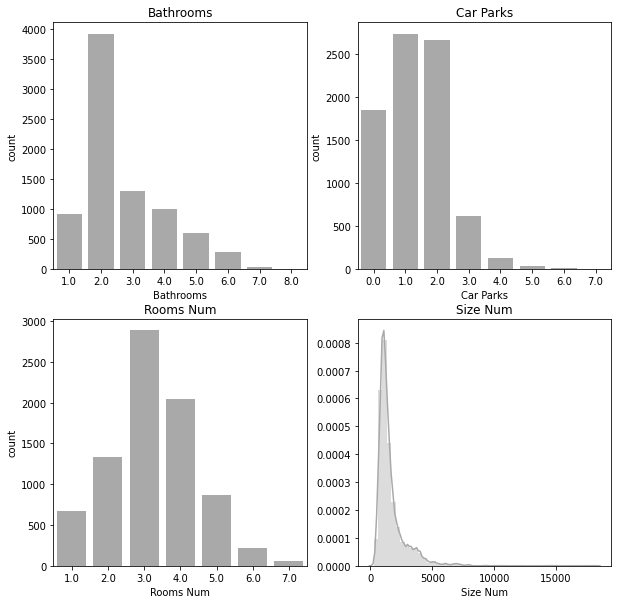

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10));
sns.countplot(data=Xy_feature_selection, x="Bathrooms", ax=ax[0, 0], color="darkgrey");
ax[0, 0].set_title("Bathrooms");
sns.countplot(data=Xy_feature_selection, x="Car Parks", ax=ax[0, 1], color="darkgrey");
ax[0, 1].set_title("Car Parks");
sns.countplot(data=Xy_feature_selection, x="Rooms Num", ax=ax[1, 0], color="darkgrey");
ax[1, 0].set_title("Rooms Num");
sns.distplot(a=Xy_feature_selection["Size Num"], bins=50, ax=ax[1, 1], color="darkgrey");
ax[1, 1].set_title("Size Num");

As none of the features seem to be normally distributed, lets simply scale them to lie between 0 and 1. Note that the data sets for training and feature selection are scaled separately. This step is not so important but it can improve the modelling. 


In [ ]:
cols = ["Bathrooms", "Car Parks", "Rooms Num", "Size Num"]
Xy_feature_selection[cols] = sklearn.preprocessing.MinMaxScaler().fit_transform(
    Xy_feature_selection[cols])
Xy[cols] = sklearn.preprocessing.MinMaxScaler().fit_transform(Xy[cols])

In [ ]:
print("Shape of data frame: {}".format(Xy.shape))

Shape of data frame: (24260, 68)


3.3 Feature Correlation

We dont need two data that will produce the same result for the modelling. Simply we only keep one. Now lets see the feature correlation between the independent variables (features).

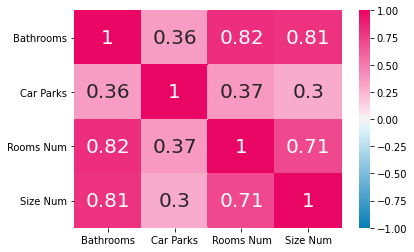

In [ ]:
hm_cmap = sns.diverging_palette(240, 0, s=99, l=50, as_cmap=True)
df = Xy_feature_selection[["Bathrooms", "Car Parks", "Rooms Num", "Size Num"]].corr()
sns.heatmap(data=df, vmin=-1, vmax=1, cmap=hm_cmap, annot=df, annot_kws={"size": 20});

Based on the above correlation matrix, the features Bathrooms and Rooms Num both correlate very strongly with Size Num and can be safely removed. 


In [ ]:
Xy = Xy.drop(["Bathrooms", "Rooms Num"], axis=1)
Xy_feature_selection = Xy_feature_selection.drop(["Bathrooms", "Rooms Num"], axis=1)

In [ ]:
print("Shape of data frame: {}".format(Xy.shape))

Shape of data frame: (24260, 66)


Now lets see the correlation of the dependent variables (features).


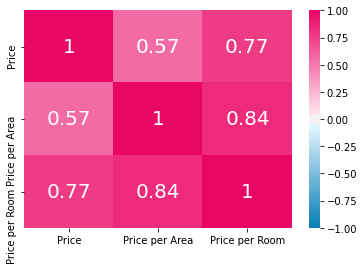

In [ ]:
df = Xy_feature_selection[["Price", "Price per Area", "Price per Room"]].corr()
sns.heatmap(
    df, vmin=-1, vmax=1, cmap=hm_cmap, 
    annot=np.round(df, 2), annot_kws={"size": 20})

Price per Area and Price per Room correlate very strongly. Therefore Price per Room is removed.

In [ ]:
Xy = Xy.drop("Price per Room", axis=1)
Xy_feature_selection = Xy_feature_selection.drop("Price per Room", axis=1)

CHAPTER 4: MODELLING

Split data into training and test set. The ratio is 80% for train and 20% for test.


In [ ]:
Xy_train, Xy_test = sklearn.model_selection.train_test_split(Xy, test_size=0.2, random_state=101)
X_train = Xy_train.drop(["Price", "Price per Area"], axis=1)
y_train = Xy_train[["Price", "Price per Area"]]
X_test = Xy_test.drop(["Price", "Price per Area"], axis=1)
y_test = Xy_test[["Price", "Price per Area"]]

Lets check the data size before feeding into the model

In [ ]:
print("Shape of data Xy_train: {}".format(Xy_train.shape))
print("Shape of data Xy_test: {}".format(Xy_test.shape))
print("Shape of data X_train: {}".format(X_train.shape))
print("Shape of data y_train: {}".format(y_train.shape))

Shape of data Xy_train: (19408, 65)
Shape of data Xy_test: (4852, 65)
Shape of data X_train: (19408, 63)
Shape of data y_train: (19408, 2)


Here is how the data looks like.

In [ ]:
X_test.head()

,Car Parks,Size Num,Location_ampang,Location_ampang hilir,Location_bandar damai perdana,Location_bandar menjalara,Location_bangsar,Location_bangsar south,Location_batu caves,Location_brickfields,Location_bukit bintang,Location_bukit jalil,Location_bukit tunku (kenny hills),Location_cheras,Location_city centre,Location_country heights damansara,Location_damansara heights,Location_desa pandan,Location_desa parkcity,Location_desa petaling,Location_dutamas,Location_jalan ipoh,Location_jalan klang lama (old klang road),Location_jalan kuching,Location_jalan sultan ismail,Location_kepong,Location_keramat,Location_kl city,Location_kl eco city,Location_kl sentral,Location_klcc,Location_kuchai lama,Location_mont kiara,Location_oug,Location_pandan perdana,Location_pantai,Location_salak selatan,Location_segambut,Location_sentul,Location_seputeh,Location_setapak,Location_setiawangsa,Location_sri hartamas,Location_sri petaling,Location_sungai besi,Location_sunway spk,Location_taman desa,Location_taman melawati,Location_taman tun dr ismail,Location_titiwangsa,Location_wangsa maju,Furnishing_Fully Furnished,Furnishing_Partly Furnished,Furnishing_Unfurnished,Property Type Supergroup_Apartment,Property Type Supergroup_Bungalow,Property Type Supergroup_Condominium,Property Type Supergroup_Flat,Property Type Supergroup_Residential Land,Property Type Supergroup_Semi-detached House,Property Type Supergroup_Serviced Residence,Property Type Supergroup_Terrace/Link House,Property Type Supergroup_Townhouse
24421,0.285714,0.074379,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
9907,0.285714,0.048494,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
8231,0.285714,0.062916,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
23369,0.142857,0.028896,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
26624,0.285714,0.061067,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0


In [ ]:
y_test.head()

,Price,Price per Area
24421,980000,591.073583
9907,740000,633.561644
8231,620000,430.256766
23369,399000,500.627353
26624,758000,539.118065


Below is the function to train and test using linear regressin model. The function simply return 3 evaulation metrics which are R-Squared, Mean Absolute Error (MAE) and Mean Squared Error (MSE).


In [ ]:
def train_and_test_model(
        model, X_train=X_train, y_train=y_train, 
        X_test=X_test, y_test=y_test, **kwargs):
    model.fit(X_train, y_train, **kwargs)
    y_pred = model.predict(X_test)

    r2 = sklearn.metrics.r2_score(y_true=y_test, y_pred=y_pred)
    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
    return model, r2, mae, mse

Now we train the model.

In [ ]:
model, r2,mae, mse = train_and_test_model(
    model = sklearn.linear_model.LinearRegression(), 
    X_train=X_train, y_train=y_train["Price"], 
    X_test=X_test, y_test=y_test["Price"])
print("R^2 for prediction of 'Price': {:.2f}".format(r2))
print("Mean absolute error for prediction of 'Price': {:.2f}".format(mae))
print("Mean squared error for prediction of 'Price': {:.2f}".format(mse))

model, r2,mae, mse = train_and_test_model(
    model = sklearn.linear_model.LinearRegression(), 
    X_train=X_train, y_train=y_train["Price per Area"], 
    X_test=X_test, y_test=y_test["Price per Area"])

print("R^2 for prediction of 'Price per Area': {:.2f}".format(r2))
print("Mean absolute error for prediction of 'Price': {:.2f}".format(mae))
print("Mean squared error for prediction of 'Price': {:.2f}".format(mse))

R^2 for prediction of 'Price': 0.67
Mean absolute error for prediction of 'Price': 466443.41
Mean squared error for prediction of 'Price': 697923604177.54
R^2 for prediction of 'Price per Area': 0.51
Mean absolute error for prediction of 'Price': 198.00
Mean squared error for prediction of 'Price': 98368.78


Neither of the targets can be predicted with a satisfying accuracy. This is most likely due to the overwhelming number of sparse binary features. So now, we will try with neural networks.


In [ ]:
def make_fcn_model():
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(units=32, activation="relu", input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(units=32, activation="relu"))
    model.add(keras.layers.Dense(units=32, activation="relu"))
    model.add(keras.layers.Dense(units=1, activation="relu"))
    model.compile(loss="mse", optimizer="Adam")
    return model

In [38]:
model, r2,mae, mse = train_and_test_model(
    model = make_fcn_model(), 
    X_train=X_train, y_train=y_train["Price"], 
    X_test=X_test, y_test=y_test["Price"], 
    batch_size=8, epochs=10, verbose=0)
print("R^2 for prediction of 'Price': {:.2f}".format(r2))
print("Mean absolute error for prediction of 'Price': {:.2f}".format(mae))
print("Mean squared error for prediction of 'Price': {:.2f}".format(mse))

model, r2,mae, mse = train_and_test_model(
    model = make_fcn_model(), 
    X_train=X_train, y_train=y_train["Price per Area"], 
    X_test=X_test, y_test=y_test["Price per Area"], 
    batch_size=8, epochs=10, verbose=0)
print("R^2 for prediction of 'Price per Area': {:.2f}".format(r2))
print("Mean absolute error for prediction of 'Price per Area': {:.2f}".format(mae))
print("Mean squared error for prediction of 'Price pe Area': {:.2f}".format(mse))

R^2 for prediction of 'Price': 0.38
Mean absolute error for prediction of 'Price': 625794.92
Mean squared error for prediction of 'Price': 1305428831301.19
R^2 for prediction of 'Price per Area': 0.56
Mean absolute error for prediction of 'Price per Area': 178.68
Mean squared error for prediction of 'Price pe Area': 88163.25


Let try another way by eliminating all the location and generalize the data only by the size num and determine only the price not price per area and also focus on regression algorithm

In [40]:
properties = pd.read_csv("/content/drive/My Drive/Properties_preprocessed.csv")

# Remove entries with "land area" in the "Size Type" column
Xy = properties.loc[properties["Size Type"] == "Built-up"]

# Keep only the relevant features
Xy = Xy.loc[:, [
    "Bathrooms", "Car Parks",
    "Rooms Num", "Size Num", 
    "Price", "Price per Area", "Price per Room"]]

# Fill missing Car Parks feature values
Xy.loc[:, "Car Parks"] = Xy["Car Parks"].fillna(0)

# Remove entries with missing values
Xy = Xy.loc[Xy.isna().sum(axis=1) == 0]

# Convert to dummy features
Xy = pd.get_dummies(Xy)

Xy = Xy.loc[Xy["Size Num"].between(250, 20000)]

selectors = []
for feature in ["Bathrooms", "Car Parks", "Rooms Num"]:
    selectors.append(Xy[feature].between(
        Xy[feature].quantile(0.001), 
        Xy[feature].quantile(0.999)))

Xy = Xy.loc[(~pd.DataFrame(selectors).T).sum(axis=1) == 0]

Xy, Xy_feature_selection = sklearn.model_selection.train_test_split(
    Xy, test_size=0.25, random_state=101)

cols = ["Bathrooms", "Car Parks", "Rooms Num", "Size Num"]


Xy = Xy.drop("Price per Room", axis=1)
Xy_feature_selection = Xy_feature_selection.drop("Price per Room", axis=1)

Xy_train, Xy_test = sklearn.model_selection.train_test_split(Xy, test_size=0.2, random_state=101)
X_train = Xy_train.drop(["Price", "Price per Area"], axis=1)
y_train = Xy_train[["Price", "Price per Area"]]
X_test = Xy_test.drop(["Price", "Price per Area"], axis=1)
y_test = Xy_test[["Price", "Price per Area"]]

In [41]:
X_train.head()

,Bathrooms,Car Parks,Rooms Num,Size Num
52181,4.0,2.0,4.0,1822.0
15273,3.0,2.0,4.0,2026.0
44848,2.0,1.0,3.0,1205.0
6421,2.0,2.0,3.0,1060.0
10039,2.0,2.0,3.0,1350.0


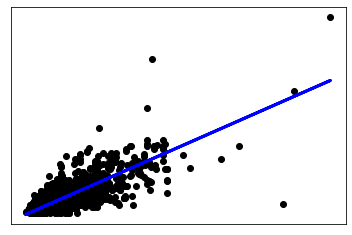

R^2 for prediction of 'Price' given size: 0.63
Mean absolute error for prediction of 'Price': 569604.56
Mean squared error for prediction of 'Price': 820569506044.59


In [42]:
def train_and_test_model(
        model, X_train=X_train, y_train=y_train, 
        X_test=X_test, y_test=y_test, **kwargs):
    model.fit(X_train, y_train, **kwargs)
    y_pred = model.predict(X_test)

    plt.scatter(X_test, y_test,  color='black')
    plt.plot(X_test, y_pred, color='blue', linewidth=3)
    plt.xticks(())
    plt.yticks(())
    plt.show()

    r2 = sklearn.metrics.r2_score(y_true=y_test, y_pred=y_pred)
    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
    return model, r2, mae ,mse

model, r2, mae, mse = train_and_test_model(
    model = sklearn.linear_model.LinearRegression(), 
    X_train=X_train[["Size Num"]], y_train=y_train["Price"], 
    X_test=X_test[["Size Num"]], y_test=y_test["Price"])
print("R^2 for prediction of 'Price' given size: {:.2f}".format(r2))
print("Mean absolute error for prediction of 'Price': {:.2f}".format(mae))
print("Mean squared error for prediction of 'Price': {:.2f}".format(mse))

In [ ]:
print(model.predict([[3000]]))

Conclusion

Both Linear Regression Model and Neural Network perform sufficiently well in predictiong the prices of property. This not strange because the properties are more complex that the feature we use here in the project. In particular, the summary statistics seen in the EDA show that the neighborhood alone accounts for massive differences in property prices. A proper price prediction model for new properties would therefore require more detailed features as scraped from the property listing itself rather than just the overview page that has been done.